# Transformer

Los Transformer son un modelo de red neuronal que ha tenido un impacto reciente en el PLN. Su arquitectura se basa en la atención, pero, a diferencia de las RNNs, no utiliza recurrencias, lo que le permite cómputos más rápidos y paralelizables.

Aquí revisamos de manera simple una arquitectura de Transformer según lo presentan Vaswani et al. (2017). Este notebook se basa en el trabajo de "The Annotated Transformer" del grupo de NLP de la Universidad de Harvard disponible en <a>https://nlp.seas.harvard.edu/2018/04/03/attention.html</a>.
Se icieron algunas modificaciones para actualizarlo a una versión reciente de Pytroch. Además, se simplificaron algunos métodos.

In [1]:
import time
import copy
from math import ceil
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import from_numpy
import math, copy
from torch.autograd import Variable
import matplotlib.pyplot as plt
from seaborn import heatmap
from collections import defaultdict
from tqdm import tqdm

# Arquitectura del Transformer

#### Copias de encoder y decoder

El modelo de Transformer se compone de un encoder y un decoder; ambas capas, además, se clonan. Es decir, se tiene $N$ capas similares del encoder y el decoder. Decimos que son similares, puesto que tienen la misma arquitectura, pero los parámetros que se aprenden pueden variar. Estas copias buscan enriquecer el procesamiento. Para hacer estas copias de las capas definimos una función:

In [2]:
def clones(module, N):
    "Produce N capas identicas (para encoder y decoder)."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#### Suma y normalización

Asimismo, a cada sub-capa en el encoder y el decoder se le agrega una normalización y una conexión residual que suma la sub-capa inmediatamente anterior.

La normalización consiste en llevar a los datos a una distibución normal estandar. Para esto se aplica la normalización siguiente (Lei Ba et al., 2016):

$$LayerNorm(X) = a \odot \frac{X-\mu}{\sigma^2 + \epsilon} + b$$

Donde $\mu$ es la media de la distribución y $\sigma^2$ la desviación estándar. El factor $\epsilon$ evita la división por 0 (en el caso de que la desviación estándar sea igual a 0). $a$ es un factor de ganancia y $b$ un bias. 

La suma se realiza entonces como:

$$x + SubLayer(LayerNorm(x))$$

Donde $SubLayer()$ es la función que se implementa en la sub-capa.

In [3]:
class LayerNorm(nn.Module):
    "Normalización de las capas."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    #Se normalizan los datos en una distribución N(0,1)
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        
class SublayerConnection(nn.Module):
    """
    Conexión residual que se agrega después de la normalización.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        #Aplica normalización
        self.norm = LayerNorm(size)
        #Aplica dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        #Se suma a la capa actual, la normalización
        return x + self.dropout(sublayer(self.norm(x)))

## Encoder

El encoder se compone de $N$ copias de una capa que se compone de:
* Auto-atención
* Red FeedForward

Además, entre cada capa, se aplica una capa de normalización y suma.

In [4]:
class Encoder(nn.Module):
    "El encoder es un conjunto de N capas simialres"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        #Clone encoder layers
        self.layers = clones(layer, N)
        #Normalización
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "A cada capa se le pasa la entrada x"
        for layer in self.layers:
            x = layer(x, mask)
        #Se obtienen las capas con normalización
        return self.norm(x)
    
class EncoderLayer(nn.Module):
    "Capa de Encoder (de la cuál se harán las copias)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        #Auto-atención
        self.self_attn = self_attn
        #FeedForward
        self.feed_forward = feed_forward
        #Conexión residual y copias
        #Se crean dos sub-capas: para la auto-atención, y para la FeedForward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        #Tamaño
        self.size = size

    def forward(self, x, mask):
        #Se aplica una capa de auto-atención y se aplica la función de sub-capa
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        #Aplica la sub-capa de FeedForward
        return self.sublayer[1](x, self.feed_forward)

## Decoder

El decoder se compone de $N$ copias de una capa que se compone de:
* Auto-atención enmascarada, el enmascaramiento "oculta" los siguientes elementos en la cadena de salida.
* Atención, entre los elementos de la entrada (salida del encoder) y de la salida.
* Red FeedForward

Además, entre cada capa, se aplica una capa de normalización y suma.

In [5]:
class Decoder(nn.Module):
    "El decoder es un conjunto de N capas similares."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        #Copia de capas decoder
        self.layers = clones(layer, N)
        #Normalización
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        "A cada capa se le pasa la entrada x, la salida del encode (memory) y máscaras"
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        #Se aplica normalización
        return self.norm(x)
        
class DecoderLayer(nn.Module):
    "Capa de Decoder"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        #Tamaño
        self.size = size
        #Auto-atención enmascarada
        self.self_attn = self_attn
        #Atención (entre encoder y decoder)
        self.src_attn = src_attn
        #FeedForward
        self.feed_forward = feed_forward
        #Conexión residual y copias
        #Se crean 3 sub-capas: auto-atención enmascarada, atención y FeedForward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        #Salida del encoder
        m = memory
        #Capa de auto-atención enmascarada
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        #Capa de atención con la memoria (salida del encoder)
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        #Capa de FeedForward
        return self.sublayer[2](x, self.feed_forward)

## Atención

La base del modelo de Transformer es la atención. Tanto el encoder como el decoder ocupan capas de atención. Pero podemos ver que se incorporan diferentes tipos de atención: auto-atención, auto-atención enmascarada y la atención (común); la auto-atención se ocupa en el encoder y busca codificar la entrada encontrando relaciones entre los elementos de la cadena de entrada. Algo similar pasa en la auto-atención enmascarada, que se ocupa en el decoder, pues busca encontrar relaciones en la salida, pero como no se conocen los elementos de salida, se asume que estos están enmascarados.

Finalmente, la atención, propiamente dicha, se aplica entre la salida del encoder y los elementos del decoder (que han pasado por la auto-atención enmascarada). En general, la atención de los Transformers se define como:

$$Attention(Q,K,V) = Softmax(\frac{QK^T}{\sqrt{d_k}})V$$

Donde $Q$ se conce como matriz query, $K$ como key y $V$ como value, y $d_k$ es la dimensión del modelo. En los modelos de auto-atención (sea enmascarada o no) estos tres elementos son copias de uno mismo. 
Pero en la atención, el query proviene del decoder, mientras que key y value provienen del encoder.

La atención en los Transformers es multi-cabezal; es decir, se crean $h$ copias de atención de la capa de atención que después se concatenan y se procesan. Esto permite que diferentes cabezales puedan poner atención a casos particulares.

In [6]:
def attention(query, key, value, mask=None, dropout=None):
    "Obtiene los pesos de atención"
    #Dimensión del modelo
    d_k = query.size(-1)
    #Calcula el producto escalado QK
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    #Si la atención es enmascarada
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    #Aplica softmax a los pesos
    p_attn = nn.functional.softmax(scores, dim = -1)
 
    #Se puede aplicar una regularización dropout
    if dropout is not None:
        p_attn = dropout(p_attn)
    #Regresa la atención softmax por V y los pesos de atención
    return torch.matmul(p_attn, value), p_attn
    
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Multi-Head Attention"
        super(MultiHeadedAttention, self).__init__()
        #dimensión del modelo debe dividir h
        assert d_model % h == 0
        #Dimensión del modelo
        self.d_k = d_model // h
        #Número de cabezales
        self.h = h
        #Copias de capas lineales
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        #Atención
        self.attn = None
        #Dropout
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        #Si hay enmascaramiento
        if mask is not None:
            # Se aplica la misma máscara a todos los cabezales
            mask = mask.unsqueeze(1)
        #Número de bathces
        nbatches = query.size(0)
        
        # 1) Realiza todas las proyecciones lineales en batch de d_model a h*d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Aplica atención a todos los vectores proyectodos en el batch
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) Concatena los cabezales de atención
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### FeedForward

La capa de FeedForward se presenta tanto en el encoder y el decoder después de las capas de atención. Esta es una simple capa definida como:

$$FFN(x) = W_2 h(x)+b_2$$

Donde:

$$h(x) = ReLU(W_1x+b_1)$$

In [7]:
class PositionwiseFeedForward(nn.Module):
    "Capa FeedForward"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        #Primera capa FeedForward
        self.w_1 = nn.Linear(d_model, d_ff)
        #Segunda capa FeedForward
        self.w_2 = nn.Linear(d_ff, d_model)
        #Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #Aplica ReLU a la primera capa
        #La segunda capa es lineal
        return self.w_2(self.dropout(nn.functional.relu(self.w_1(x))))

### Embeddings

Los embeddings en los modelos de Tranformer son contextualizados, pero para contextualizarlos, se utiliza una codificación posicional.

En primer lugar se ocupa una capa típica de embedding (estáticos). Estos embeddings se escalan multiplicando por $\sqrt{d}$ donde $d$ es la dimensión de los embeddings.

Cuando se tienen estos embeddings, se les suma una codificación posicional que indica la posición del elemento en la cadena. Esta codificación de posición es un vector que tiene senos en las entradas pares y cosenos en las impares. Es decir, las entradas pares del vector son:

$$PE_{2i}(t) = \sin \Big(\frac{t}{10000^{2 i/d}} \Big)$$

Mientras que las entradas impares son:

$$PE_{2i+1}(t) = \cos \Big(\frac{t}{10000^{2 i/d}} \Big)$$

Donde $t$ es la posición del elemento e $i$ es la entrada del vector de posición.

Esto hace que la posición se codifique como una señal. En la práctica, el factor $10000^{2 i/d}$ puede aplicarse con un logaritmo (seguido de una exponencial) para evitar que se desvanezca.

In [8]:
#Common embeddings
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        #Capa de embedding estáticos
        self.lut = nn.Embedding(vocab, d_model) 
        #Dimensión de embeddings
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
        
#Positional embeddings
class PositionalEncoding(nn.Module):
    "Codificación posicional"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        #Dropout
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        #Matriz de dimensión de embeddings por máximo núm de elementos
        pe = torch.zeros(max_len, d_model)
        #Posición de 0 a máximo núm de elementos (enteros)
        position = torch.arange(0, max_len).unsqueeze(1)
        #Factor de la división con log y exp
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        #Entradas pares
        pe[:, 0::2] = torch.sin(position * div_term)
        #Entradas impares
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        #Suma del embedding estático más codificación posicional
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        #Dropout
        return self.dropout(x)

La codificación posicional puede visualizarse como señales de seno y coseno con diferente amplitud.

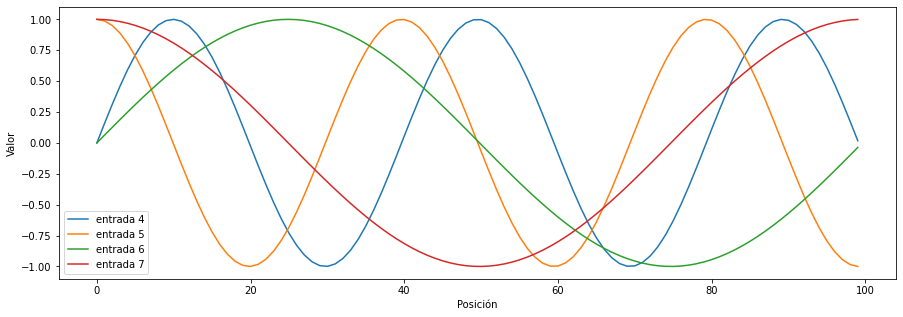

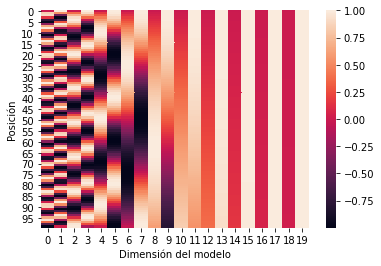

In [9]:
#Visualización de PE
d_model = 20
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(d_model, 0)
y = pe.forward(Variable(torch.zeros(1, 100, d_model)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["entrada %d"%p for p in [4,5,6,7]])
plt.xlabel('Posición')
plt.ylabel('Valor')
plt.show()

heatmap(y.data.numpy()[0])
plt.ylabel('Posición')
plt.xlabel('Dimensión del modelo')
plt.show()

### Salida del Transformer

Después de pasar por el Encoder y el Decoder, la salida del Transformer es una capa lineal, de la cual se obtienen probabilidades por medio de una función Softmax.

In [10]:
class Generator(nn.Module):
    "Salida del Trasnformer."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        #Capa lineal
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        #Softmax
        return nn.functional.softmax(self.proj(x), dim=-1)

## Arquitectura total

Para reunir todos los módulos que conforman la arquitectura del Transformer, definirmos una función que tomará cada uno de los elementos que hemos definido.

In [11]:
class EncoderDecoder(nn.Module):
    """
    Arquitectura Encoder-Decoder.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        #Encoder
        self.encoder = encoder
        #Decoder
        self.decoder = decoder
        #Embeddings de entrada
        self.src_embed = src_embed
        #Embeddings de salida
        self.tgt_embed = tgt_embed
        #Salida del Encoder-Decoder
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        #Función de decodificación
        #Codifica y decodifica
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        #Función de codificación
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        #Función de decodificación
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


# Optimización

La optimización en los transformers se realiza a partir de un optimizador Noam. Antes de revisar este optimizador, introducimos funciones para el cómputo de los batches en la optimización. Estas funciones toman en cuenta el enmascaramiento de palabras subsecuentes en la salida. Este enmascaramiento permite la predicción de cadenas de salida que no hayan sido vistas. Para cada cadena de entrada, la cadena de salida asume que las palabras que va a predecir están enmascaradas.

In [12]:
def subsequent_mask(size):
    "Enmascara las posiciones subsecuentes."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return from_numpy(subsequent_mask) == 0

class Batch:
    "Almacena un batch de los datos enmascarados durante el entrenamoento."
    def __init__(self, src, trg=None, pad=0):
        #Input e input mask
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        #Output
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Crea una máscara para ocultar palabras futuras (y el padding)."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Aumenta batch y calcula el número total de tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

El <b>optimizador Noam</b> está basado en el optimizador Adam, pero en cada paso $t$ (step) varía el rango de aprendizaje $\eta$ de acuerdo con la siguiente fórmula:

$$\eta_t = \frac{\alpha}{\sqrt{d_{model}}} \min\{t^{-1/2}, t \omega^{-3/2}\}$$

Donde $\alpha$ es un "factor", generalmente $\alpha = 2$ y $d_{model}$ (model_size) es la dimensión de los embeddings del modelo. Además $\omega$ (warmup) es un hiperparámetro que que corresponde al incremento del rango de aprendizaje de forma lineal y su decremento es proporcional al inverso del cuadrado del paso.

In [13]:
class NoamOpt:
    "Optimizador Noam."
    def __init__(self, model_size, factor, warmup, optimizer):
        #optimizador
        self.optimizer = optimizer
        #Inicialización de paso
        self._step = 0
        #Hiperparámetro de warmup
        self.warmup = warmup
        #Hiperparámetro de factor
        self.factor = factor
        #Tamaño del modelo
        self.model_size = model_size
        #Rango
        self._rate = 0
        
    def step(self):
        "Actualiza el paso y los parámetros"
        #Aumenta step
        self._step += 1
        #rango
        rate = self.rate()
        #Observa parámetros de Adam y guarda el rango de aprendizaje
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        #Actualiza el paso en Adam
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implementa el método de Noam"
        #Inicio
        if step is None:
            step = self._step
        #Rango de aprendizaje según método Noam
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

Finalmente, para la optiimización definimos las funciones que nos servirán para calcular la pérdida y correr cada una de las épocas en el entrenamiento.

In [14]:
def run_epoch(data_iter, model, loss_compute):
    "Función estándar de entrenamiento"
    #Inicio
    start = time.time()
    #Núm tokens
    total_tokens = 0
    #Riesgo
    total_loss = 0
    #Tokens
    tokens = 0
    for i, batch in enumerate(data_iter):
        #Calcula la salida de Transformer
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        #Computa el riesgo
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        #Acumula el riesgo
        total_loss += loss
        #Cuenta los tokens del batch
        total_tokens += batch.ntokens
        tokens += batch.ntokens
    return total_loss / total_tokens

class SimpleLossCompute:
    "Computo del riesgo y funció de entrenamiento."
    def __init__(self, generator, criterion, opt=None):
        #Generador
        self.generator = generator
        #Funcíon de riesgo / criterio
        self.criterion = criterion
        #Optimizador
        self.opt = opt
        
    def __call__(self, x, y, norm):
        #Calcula x con el generador del modelo
        x = self.generator(x)
        #Calcula el riesgo
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        #Retropropaga
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

# Aplicación del modelo

Para crear el modelo de Transformer a partir de los diferentes modulos que hemos definido, daremos una función que creará la arquitectura a partir de los hiperparámetros que le indiquemos:

In [15]:
def make_model(src_vocab, tgt_vocab, N=1,d_model=128, d_ff=256, h=1, dropout=0.1):
    "Construye un modelo a partir de los hiperparámetros."
    #Función para hacer copias de capas
    c = copy.deepcopy
    #Atención multi-cabezal
    attn = MultiHeadedAttention(h, d_model)
    #Capa FeedForward
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    #Codificación posicional
    position = PositionalEncoding(d_model, dropout)
    
    #Encoder
    encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
    #Decoder
    decoder = Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N)
    #Embeddings de entrada
    src_embed = nn.Sequential(Embeddings(d_model, src_vocab), c(position))
    #Embeddings de salida
    tgt_embed = nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))
    #Salida de todo el Transformer
    generator = Generator(d_model, tgt_vocab)
    #Creación del modelo
    model = EncoderDecoder(encoder,decoder,src_embed,tgt_embed,generator)
     
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

Para entrenar por batches, definimos una función que tomará los datos de entrada y salida y regresará los batches de tamaño especificado.

In [16]:
def batch_gen(X,Y,batch):
    "Genera batch para input-output."
    num_ex = X.shape[0]
    nbatches = ceil(num_ex/batch)
    for i in range(nbatches):
        src = Variable(X[i:i+batch], requires_grad=False)
        tgt = Variable(Y[i:i+batch], requires_grad=False)
        yield Batch(src, tgt, 0)

#### Preparación de los datos

Definiremos una tarea sencilla de etiquetado POS, es decir, la entrada será una cadena en español y la salida las etiquetas POS de cada palabra. Definimos antes las funciones para el vocabulario y la indexación de las palabras, así como agregar el padding y símbolos de inicio y final.

In [17]:
#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.strip().split()]
        
        
#Índices de símbolos especiales
PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2

#Función para hacer padding
def insert_pad(lista, PAD_IDX=PAD_IDX):    
    l = max([len(cad) for cad in lista])
    pad_lista = []
    for cad in lista:
        pad_cad = cad + [PAD_IDX for i in range(l-len(cad))]
        pad_lista.append(pad_cad)
    return pad_lista

#Funcuón para insertar símbolos a las cadenas
def process_seqs(seqs,BOS_IDX=BOS_IDX,EOS_IDX=EOS_IDX):
    return insert_pad([[BOS_IDX] + cad + [EOS_IDX] for cad in seqs])

Preparamos los datos insertando símbolos de inicio y fin e indexando las palabras.

In [18]:
src = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
        'un gato come croquetas']
tgt = ['DA NC V DD NC', 'DD NC V', 'DA NC V DA NC', 'DD NC V NC']

#Crear vobulario y cadenas
#Lenguaje fuente
src_voc = vocab()
src_voc['<PAD>'] = PAD_IDX
src_voc['<BOS>'] = BOS_IDX
src_voc['<EOS>'] = EOS_IDX
src_cads = process_seqs(list(text2numba(src,src_voc)))

#Crear vocabulario y cadenas
#Lenguaje objetivo
tgt_voc = vocab()
tgt_voc['<PAD>'] = PAD_IDX
tgt_voc['<BOS>'] = BOS_IDX
tgt_voc['<EOS>'] = EOS_IDX
tgt_cads = process_seqs(list(text2numba(tgt,tgt_voc)))
#Longitudes de los vocabulario
len_src, len_tgt = len(src_voc), len(tgt_voc)

X, Y = torch.tensor(src_cads), torch.tensor(tgt_cads)

print(X[1],Y[1])

tensor([1, 6, 8, 9, 2, 0, 0]) tensor([1, 6, 4, 5, 2, 0, 0])


#### Generación del modelo

Para crear el modelo debemos indicar los hiperparámetros que determinarán el número de pesos a optimizar. Estos hiperparámetros son:

* $N$: Número de copias del encoder y el decoder.
* d_model: dimensión del modelo.
* d_ff: Tamaño de la capa en la FeedForward.
* $h$: número de cabezales en la atención.

In [19]:
#Creamos el modelo con hiperparámetros
model = make_model(len_src, len_tgt, N=1, d_model=100, d_ff=20, h=1)
print(model)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=100, out_features=100, bias=True)
            (1): Linear(in_features=100, out_features=100, bias=True)
            (2): Linear(in_features=100, out_features=100, bias=True)
            (3): Linear(in_features=100, out_features=100, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=100, out_features=20, bias=True)
          (w_2): Linear(in_features=20, out_features=100, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

#### Entrenamiento

Para entrenar, usaremos la función de riesgo de entropía cruzada y el optimizador Noam. Aplicamos la función de correr época y utilizamos el computo de riesgo que hemos definido más arriba.

In [20]:
#Riesgo entropía cruzada
criterion = nn.CrossEntropyLoss()
#Optimizador Noam
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 4000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in tqdm(range(300)):
        model.train()
        #Correr las épocas necesarias
        run_epoch(batch_gen(X, Y, 1), model, SimpleLossCompute(model.generator, criterion, opt=model_opt))

100%|██████████| 300/300 [00:10<00:00, 27.74it/s]


### Evaluación

Para la evaluación definiremos una función que aplica el modelo de Transformer a una entrada, generando una cadena con los elementos más probables. También definimos las funciones que transforman la entrada en tensores de Torch, y la salida en etiquetas.

In [21]:
model.eval()

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    "Aplica el Tranformer a los datos"
    #Encoder
    memory = model.encode(src, src_mask)
    #Inicializa con el símbolo de inicio
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        #Decoder
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        #Salida del transformer (probabilidades)
        prob = model.generator(out[:, -1])
        #Regresa el elemento con mayor prob
        _, next_word = torch.max(prob, dim = 1)
        #Adjunta este elemento a la cadenas de salida
        next_word = next_word.data[0]
        #Acumula cadena de salida
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

def get_x_input(sents):
    "Transforma la entrada en formato del modelo"
    x_sents = []
    for sent in sents:
        x_sent = []
        for w in sent.split():
            idx_w = src_voc[w]
            x_sent.append(idx_w)
        x_sents.append([BOS_IDX] + x_sent + [EOS_IDX])
        
    return Variable(torch.LongTensor(x_sents))

tgt_voc_rev = {k:v for v,k in tgt_voc.items()}
def get_output(y):
    "Transforma la salida en símbolos originales"
    sent = y.detach().tolist()[0]
    return ' '.join([tgt_voc_rev[word] for word in sent if word != 0])

Finalmente, podemos cuál es la salida para el caso de ejemplos particulares y visualizar los pesos de atención que se determinaron en cada una de las salidas.

el perro come la cuerda --> <BOS> DA NC V DD NC <EOS>


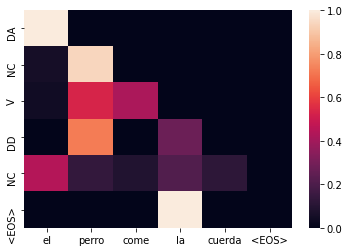

el gato jugaba --> <BOS> DD NC V NC


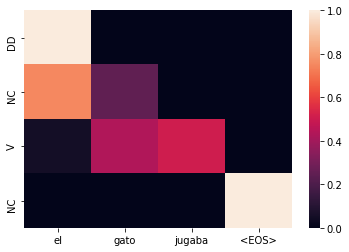

In [22]:
sents = ['el perro come la cuerda', 'el gato jugaba']

for sent in sents:
    x_input = get_x_input([sent])
    output = greedy_decode(model, x_input, Variable(torch.ones(1, 1, x_input.shape[1])), 
                            max_len=x_input.shape[1], start_symbol=1)
    print('{} --> {}'.format(sent, get_output(output)))
    
    #Pesos de atención
    att = model.decoder.layers[0].self_attn.attn[0].data[:output.shape[1], :x_input.shape[1]][0]
    heatmap(att, xticklabels=sent.split()+['<EOS>'], yticklabels=get_output(output).split()[1:])
    plt.show()

#### Visualización de embeddings

El modelo de Transformer genera embeddings (estáticos) para el vocabulario de entrada y de salida.

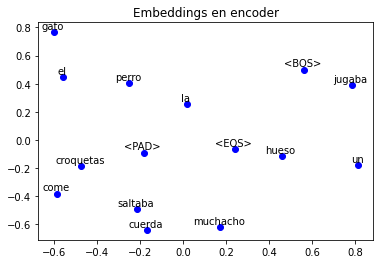

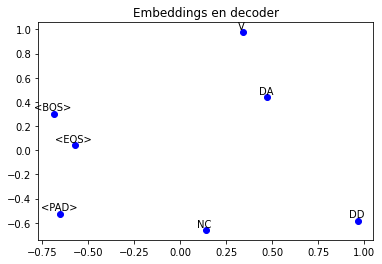

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Función para plotear
def plot_words(Z,ids,color='blue'):
    #Reduce a dos dimensiones con PCA
    Z = PCA(n_components=2).fit_transform(Z)
    r=0
    #Plotea las dimensiones
    plt.scatter(Z[:,0],Z[:,1], marker='o', c=color)
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        #Agrega las etiquetas
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
        
src_embs = np.array(model.src_embed[0].lut.weight.detach())
tgt_embs = np.array(model.tgt_embed[0].lut.weight.detach())

plot_words(src_embs,src_voc.keys())
plt.title('Embeddings en encoder')
plt.show()

plot_words(tgt_embs,tgt_voc.keys())
plt.title('Embeddings en decoder')
plt.show()